In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('drive/MyDrive/Colab/Task4')

In [ ]:
!nvidia-smi
!pip install allennlp

## 1. 数据处理
### 1.1 数据文件预处理

In [ ]:
def readFile(path):
    dic = {'Data':[], 
           'Label':[]}

    with open(path) as fp:
        lines = fp.readlines()
        curr_datas = []   # 当前读取的句子
        curr_labels = []

        for line in lines:
            line = line.strip('\n').split()

            if len(line) == 0 or line[0] == '-DOCSTART-':
                if len(curr_datas) != 0:
                    dic['Data'].append(curr_datas)
                    dic['Label'].append(curr_labels)
                curr_datas = []
                curr_labels = []
            else:
                curr_datas.append(line[0].lower())
                curr_labels.append(line[3])
        
        # 读取最后一句
        if len(curr_datas) != 0:
            dic['Data'].append(curr_datas)
            dic['Label'].append(curr_labels)
        
        return dic

In [ ]:
import pandas as pd

train_dic = readFile('dataset/train.txt')
val_dic = readFile('dataset/valid.txt')
test_dic = readFile('dataset/test.txt')

pd.DataFrame(train_dic).to_csv('dataset/train.csv')
pd.DataFrame(val_dic).to_csv('dataset/val.csv')
pd.DataFrame(test_dic).to_csv('dataset/test.csv')

In [ ]:
pd.DataFrame(train_dic)

,Data,Label
0,"[eu, rejects, german, call, to, boycott, briti...","[B-ORG, O, B-MISC, O, O, O, B-MISC, O, O]"
1,"[peter, blackburn]","[B-PER, I-PER]"
2,"[brussels, 1996-08-22]","[B-LOC, O]"
3,"[the, european, commission, said, on, thursday...","[O, B-ORG, I-ORG, O, O, O, O, O, O, B-MISC, O,..."
4,"[germany, 's, representative, to, the, europea...","[B-LOC, O, O, O, O, B-ORG, I-ORG, O, O, O, B-P..."
...,...,...
14036,"[on, friday, :]","[O, O, O]"
14037,"[division, two]","[O, O]"
14038,"[plymouth, 2, preston, 1]","[B-ORG, O, B-ORG, O]"
14039,"[division, three]","[O, O]"


### 1.2 统计句子长度分布

113


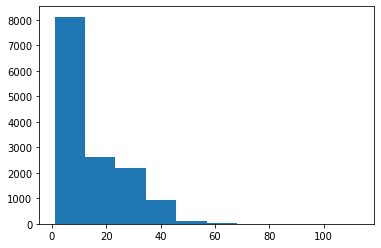

In [ ]:
import matplotlib.pyplot as plt

# 统计句子长度分布
train_datas = pd.read_csv('dataset/train.csv')
len_arr = [len(eval(x)) for x in train_datas['Data']]
plt.hist(len_arr)
print(max(len_arr))

由于句子的长度参差不齐，我决定不使用截长补短，而是把每个batch的数据padding到最长的句子。

### 1.3 建立词表
预训练词向量采用的是glove

In [ ]:
import pandas as pd
import numpy as np

# 建立词表
class VocabProcessor():
    def run(self, train_path='dataset/train.csv', glove_path="../glove/glove.6B.300d.txt"):
        glove = self.processGlove(glove_path)
        vocab = self.buildVocab(train_path, glove)
        return vocab    

    # 读取GloVe文件
    def processGlove(self, glove_path):
        word2idx = {}
        vectors = []
        with open(glove_path) as fp:
            lines = fp.readlines()
            
            for i, line in enumerate(lines):
                line = line.strip('\n').split()
                word2idx[line[0]] = i 
                vectors.append(np.array(list(map(float, line[1:])), dtype=np.float32))
            fp.close()
        
        return {"word2idx":word2idx, "glove_vectors":vectors}

    # 利用训练集建立词表
    def buildVocab(self, train_path, glove):
        vocab = ['<pad>', '<unk>']
        word2idx = {'<pad>':0, '<unk>':1}
        
        datas = pd.read_csv(train_path)

        curr_idx = 2
        for index, line in datas.iterrows():
            text = eval(line['Data'])
            # 逐个词进行判断
            for word in text:
                # 如果词不在glove的词表里或词已经在词表里，则跳过
                if not (word in glove["word2idx"]) or word in word2idx:
                    continue
                else:
                    vocab.append(word)
                    word2idx[word] = curr_idx
                    curr_idx = curr_idx + 1

        
        # 建立词向量大矩阵
        glove_vectors = np.zeros((len(vocab), 300), dtype=np.float32)

        # 随机初始化<unk>
        glove_vectors[1] = np.random.randn((300))

        for i in range(2, len(vocab)):
            word = vocab[i]
            glove_idx = glove["word2idx"][word]
            glove_vectors[i] = glove["glove_vectors"][glove_idx]

        return {"word2idx":word2idx, "glove_vectors":glove_vectors}

In [ ]:
vocab_processor = VocabProcessor()
glove_vocab = vocab_processor.run()

### 1.4 向量化数据集
我采用的是BIO的标注方法，标签编码：
- O 0
- B-PER 1
- I-PER 2
- B-LOC 3
- I-LOC 4
- B-ORG 5
- I-ORG 6
- B-MISC 7
- I-MISC 8


In [ ]:
import torch.utils.data

class CONLL2003Dataset(torch.utils.data.Dataset):
    label_dict = {
        "O":0,
        "B-PER":1, 
        "I-PER":2, 
        "B-LOC":3,
        "I-LOC":4,
        "B-ORG":5,
        "I-ORG":6,
        "B-MISC":7,
        "I-MISC":8,
        }
    
    
    def __init__(self, path, vocab):
        super(CONLL2003Dataset).__init__()
        self.datas = []
        self.vocab = vocab
        datas = pd.read_csv(path)

        for index, line in datas.iterrows():
            self.datas.append({"data":self._numerical_text(eval(line['Data'])),
                               "label":self._numerical_label(eval(line['Label']))})
    
    def __getitem__(self, index):
        return self.datas[index]
    
    def __len__(self):
        return len(self.datas)

    def _numerical_text(self, line):
        result = np.zeros((len(line)), dtype=np.long)
        # 序列化
        unk_idx = self.vocab['word2idx']['<unk>']
        for i, word in enumerate(line):
            if not (word in self.vocab["word2idx"]): # 不在词表的词
                result[i] = unk_idx
            else:
                word_idx = self.vocab['word2idx'][word]
                result[i] = word_idx
        
        return result

    def _numerical_label(self, line):
        label = np.zeros((len(line)), dtype=np.long)
        for i, x in enumerate(line): # 检查一下label是否合法
            if x not in self.label_dict:
                print(x)
            else:
                label[i] = self.label_dict[x]
        return label

In [ ]:
train_path = "dataset/train.csv"
val_path = "dataset/val.csv"
test_path = "dataset/test.csv"

train_dataset = CONLL2003Dataset(train_path, glove_vocab)
val_dataset = CONLL2003Dataset(val_path, glove_vocab)
test_dataset = CONLL2003Dataset(test_path, glove_vocab)

In [ ]:
val_dataset[2]

{'data': array([ 955, 5118, 2162, 1599, 1941,  725, 2045,   66, 8166,   18, 1046,
         138, 1939, 1664, 1914,   89,  152, 1979,   82, 3484, 2812,  225,
         384,  904,    6,  206,  735,  151,   14, 1715,  156,   14, 1900,
        1901,   10]),
 'label': array([7, 8, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 5, 0, 5, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])}

In [ ]:
import pickle

cache = {"glove_vocab":glove_vocab,
         "train_dataset":train_dataset,
         "val_dataset":val_dataset,
         "test_dataset":test_dataset}

# 缓存预处理后的数据，加速多次训练
with open("cache/preprocess.pickle", 'wb') as fp:
    pickle.dump(cache, fp)

In [ ]:
import pickle

# 读取缓存
with open("cache/preprocess.pickle", 'rb') as fp:
    cache = pickle.load(fp)
glove_vocab = cache["glove_vocab"]
train_dataset= cache["train_dataset"]
val_dataset= cache["val_dataset"]
test_dataset= cache["test_dataset"]

## 2. LSTM-CRF模型
这里使用最简单的bilstm+CRF模型
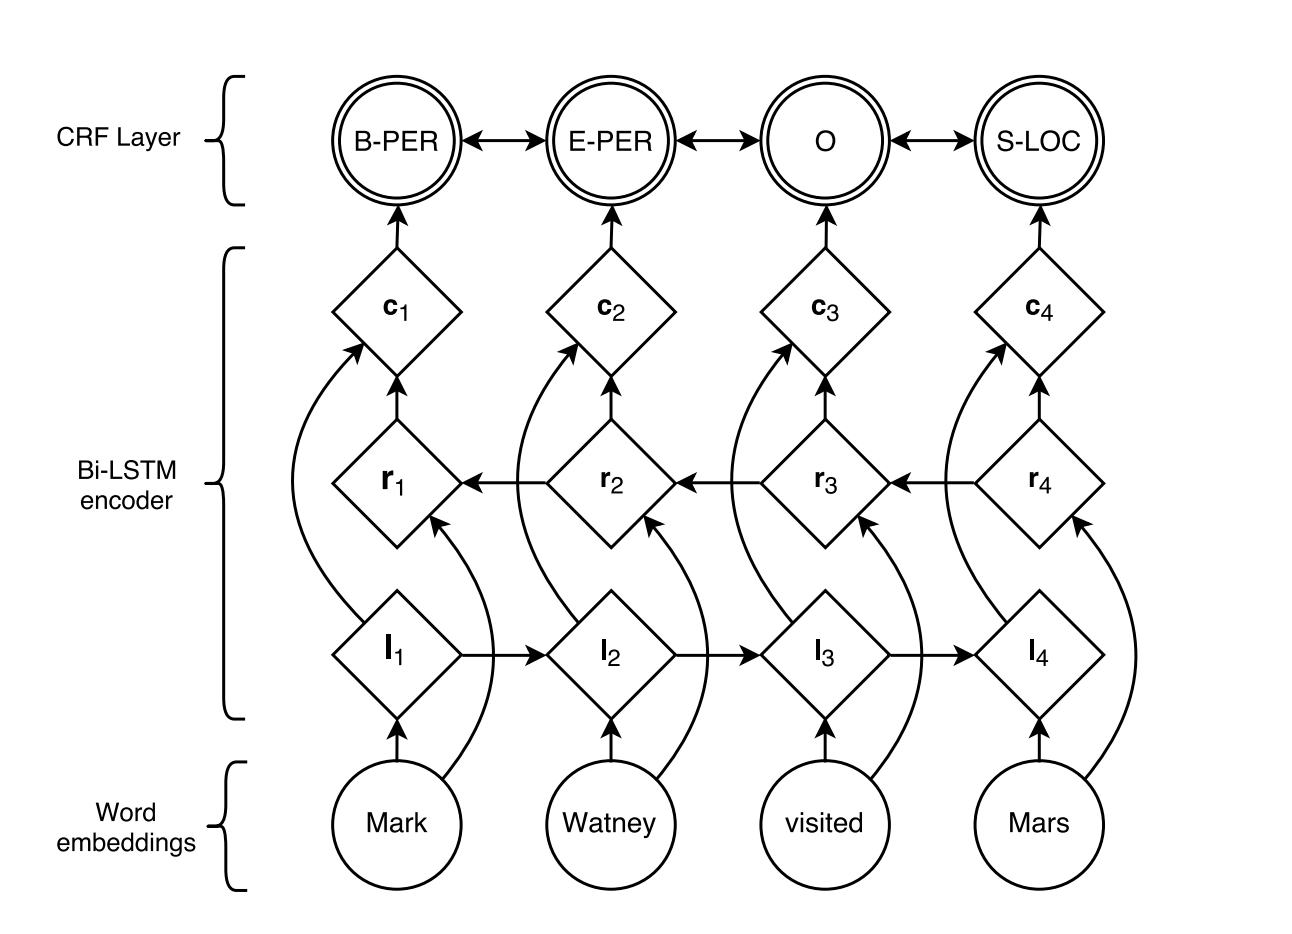

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from allennlp.modules.conditional_random_field import ConditionalRandomField

# 初始化参数
def init_weights(module):
    if isinstance(module, nn.Linear):
        nn.init.xavier_uniform_(module.weight.data)
        nn.init.constant_(module.bias.data, 0.0)

    elif isinstance(module, nn.LSTM):
        nn.init.xavier_uniform_(module.weight_ih_l0.data)
        nn.init.orthogonal_(module.weight_hh_l0.data)
        nn.init.constant_(module.bias_ih_l0.data, 0.0)
        nn.init.constant_(module.bias_hh_l0.data, 0.0)
        hidden_size = module.bias_hh_l0.data.shape[0] // 4
        module.bias_hh_l0.data[hidden_size:(2*hidden_size)] = 1.0

        if (module.bidirectional):
            nn.init.xavier_uniform_(module.weight_ih_l0_reverse.data)
            nn.init.orthogonal_(module.weight_hh_l0_reverse.data)
            nn.init.constant_(module.bias_ih_l0_reverse.data, 0.0)
            nn.init.constant_(module.bias_hh_l0_reverse.data, 0.0)
            module.bias_hh_l0_reverse.data[hidden_size:(2*hidden_size)] = 1.0 

class BiLstmCRF(nn.Module):
    def __init__(self, args, vocab):
        super(BiLstmCRF, self).__init__()
        self.args = args

        # Embedding Layer
        self.embedding = nn.Embedding.from_pretrained(vocab, freeze=True)

        # Input Encoding Layer
        self.encoding = nn.LSTM(input_size=args.embed_size,
                                hidden_size=args.hidden_size,
                                num_layers=1,
                                batch_first=True,
                                bidirectional=True)

        # Feedforward Neural Networks Layer
        self.feedforward = nn.Sequential(nn.Linear(2*args.hidden_size,
                                                  args.hidden_size),
                                        nn.Tanh(),
                                        nn.Dropout(p=args.dropout_rate),
                                        nn.Linear(args.hidden_size,
                                                  args.label_num))
        
        # Conditional Random Field
        self.crf = ConditionalRandomField(args.label_num)

        # Dropout Layer
        self.dropout = nn.Dropout(args.dropout_rate)

        self.apply(init_weights)

    # bilstm编码
    def _seq_encoding(self, lstm, seqs, seqs_mask):
        batch_size = seqs.shape[0]
        outputs, _ = lstm(seqs)
        masked_outputs = outputs * seqs_mask.view(batch_size, -1, 1)
        return masked_outputs

    def forward(self, 
                text,
                mask,
                label):
        # Embedding Layer
        # (batch_size, length) -> (batch_size, length, embed_dim)
        embed_text = self.embedding(text)

        # Input Encoding Layer
        # (batch_size, length, embed_dim) -> (batch_size, length, 2 * hidden_dim)
        encoded_text = self._seq_encoding(self.encoding, 
                                             embed_text, 
                                             mask)
        
        # dropout
        encoded_text = self.dropout(encoded_text)
        
        # Feed Forward Layer
        # (batch_size, 2 * hidden_dim) -> (batch_size, 3)
        out = self.feedforward(encoded_text)
        
        loss = -self.crf(out, label, mask)
        res = self.crf.viterbi_tags(out, mask, 1)
        return res, loss

## 3. 训练函数

### 3.1 计算Precision Recall F1
$$F1 = \frac{2 * Precision * Recall}{Precision + Recall}$$


$$Precision=\frac{TP}{TP+FP}$$


$$Recall=\frac{TP}{TP+FN}$$

In [ ]:
idx2label = ["O", "B-PER", "I-PER", "B-LOC", "I-LOC", "B-ORG", "I-ORG", "B-MISC","I-MISC"]

# label -- TP+FN
# model output -- TP+FP
def CalAspectNum(cls):
    cls = cls.tolist()
    res = 0.
    
    for x in cls:  
        if idx2label[x][0] == 'B': # 通过计算B的数量来计算实体的个数
            res += 1
    return res

# TP
def CalSameAspectNum(output, label):
    output = output.tolist()
    label = label.tolist()
    res = 0.
    seq_len = len(label)
    for i in range(seq_len):  
        # 计算完全匹配的实体个数
        if idx2label[label[i]][0] == 'B' and label[i] == output[i]:
            res += 1
            while (i + 1) < seq_len and (idx2label[label[i]][0] == "I" or idx2label[output[i]][0] == "I"):
                if label[i] != output[i]:
                    res -= 1
                    break
                else:
                    i += 1
    return res

### 3.2 训练过程函数

In [ ]:
def collate_fn(batch_data):
    batch_size = len(batch_data)

    # 以batch中最长的句子作为长度进行padding
    max_len = max([len(x['data']) for x in batch_data])

    vec = torch.ones((batch_size, max_len), dtype=torch.int64)
    mask = torch.zeros((batch_size, max_len), dtype=torch.bool)
    padded_label = torch.zeros((batch_size, max_len), dtype=torch.int64)
    for i, example in enumerate(batch_data):
        for j, x in enumerate(example['data']):
            vec[i, j] = x
            mask[i, j] = 1
        
        for j, x in enumerate(example['label']):
            padded_label[i, j] = x
    
    return (vec, mask, padded_label)

In [ ]:
from tqdm import tqdm
import numpy as np

def train_progress(args, model, optimizer, train_dataloader, val_dataloader, test_dataloader, device):
    train_f1_arr = []
    train_loss_arr = []
    val_f1_arr = []
    val_loss_arr = []
    best_val_loss = 1e9
    best_val_epoch = -1
    
    for epoch in range(args.epochs):
        print(f"Epoch {epoch}:")

        # Training
        train_len = 0
        train_loss = 0.
        train_aspect_num = np.asarray([0., 0., 0.])

        model.train()
        for step, datas in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
            optimizer.zero_grad()
            
            text, mask, labels = [data.to(device) for data in datas]
            
            output, loss = model(text, mask, labels)
            output = torch.tensor([y for x in output for y in x[0][0]])
            labels = torch.masked_select(labels, mask).cpu()

            # 训练
            loss = loss.cpu()
            loss.backward()
            optimizer.step()

            # 统计结果
            train_len += 1
            train_loss += loss.item()
            train_aspect_num += np.asarray([CalAspectNum(output), CalAspectNum(labels), CalSameAspectNum(output, labels)])

            # 实体统计量
        
        # Precision & Recall
        P = train_aspect_num[2] / train_aspect_num[0]
        R = train_aspect_num[2] / train_aspect_num[1]
        F1 = (2 * P * R) / (P + R)

        train_loss = train_loss / train_len
        train_loss_arr.append(train_loss)
        train_f1_arr.append(F1)
        print(f"Train: | loss: {train_loss}")
        print(f"Train: | Precision: {P} | Recall: {R} | F1 score: {F1}")

        # Validation
        val_len = 0
        val_loss = 0.
        val_aspect_num = np.asarray([0., 0., 0.])

        model.eval()
        with torch.no_grad():
            for step, datas in enumerate(val_dataloader):
                text, mask, labels = [data.to(device) for data in datas]
            
                output, loss = model(text, mask, labels)
                output = torch.tensor([y for x in output for y in x[0][0]])
                labels = torch.masked_select(labels, mask).cpu()

                # 训练
                loss = loss.cpu()

                # 统计结果
                val_len += 1
                val_loss += loss.item()
                val_aspect_num += np.asarray([CalAspectNum(output), CalAspectNum(labels), CalSameAspectNum(output, labels)])

        # Precision & Recall
        P = val_aspect_num[2] / val_aspect_num[0]
        R = val_aspect_num[2] / val_aspect_num[1]
        F1 = (2 * P * R) / (P + R)

        val_loss = val_loss / val_len
        val_loss_arr.append(val_loss)
        val_f1_arr.append(F1)
        print(f"Validation: | loss: {val_loss}")
        print(f"Validation: | Precision: {P} | Recall: {R} | F1 score: {F1}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_val_epoch = epoch
            torch.save(model.state_dict(), "models/best_model.pth")
        
        # Early stop
        if epoch - best_val_epoch >= 5:
            print("Early Stop!")
            break

    # Test
    best_checkpoint = torch.load("models/best_model.pth")
    model.load_state_dict(best_checkpoint)
    test_len = 0
    test_loss = 0.
    test_aspect_num = np.asarray([0., 0., 0.])

    model.eval()
    with torch.no_grad():
        for step, datas in enumerate(test_dataloader):
            text, mask, labels = [data.to(device) for data in datas]
            
            output, loss = model(text, mask, labels)
            output = torch.tensor([y for x in output for y in x[0][0]])
            labels = torch.masked_select(labels, mask).cpu()

            # 训练
            loss = loss.cpu()

            # 统计结果
            test_len += 1
            test_loss += loss.item()
            test_aspect_num += np.asarray([CalAspectNum(output), CalAspectNum(labels), CalSameAspectNum(output, labels)])
    
    # Precision & Recall
    P = test_aspect_num[2] / test_aspect_num[0]
    R = test_aspect_num[2] / test_aspect_num[1]
    F1 = (2 * P * R) / (P + R)

    test_loss = test_loss / test_len
    print(f"\n\nTest: | loss: {test_loss}")
    print(f"Test: | Precision: {P} | Recall: {R} | F1 score: {F1}")
    return (train_loss_arr, train_f1_arr), (val_loss_arr, val_f1_arr)

## 4. 训练和分析
### 4.1 超参数

In [ ]:
class Arguments():
    epochs = 50
    batch_size = 64
    lr = 5e-4
    embed_size = 300
    hidden_size = 300
    dropout_rate = 0.5
    label_num = 9

### 4.2 训练过程

In [ ]:
import torch.optim

args = Arguments()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vocab =  torch.Tensor(glove_vocab["glove_vectors"])
model = BiLstmCRF(args, vocab)
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

if torch.cuda.is_available():
    model.cuda()

In [ ]:
import torch.utils.data

train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=args.batch_size,
                                           collate_fn=collate_fn,
                                           shuffle=True)
val_dataloader = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_size=args.batch_size,
                                           collate_fn=collate_fn,
                                           shuffle=False)
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=args.batch_size,
                                           collate_fn=collate_fn,
                                           shuffle=False)

train_record, val_record = train_progress(args=args, 
                                          model=model,
                                          optimizer=optimizer,
                                          train_dataloader=train_dataloader, 
                                          val_dataloader=val_dataloader, 
                                          test_dataloader=test_dataloader, 
                                          device=device)

Epoch 0:


100%|██████████| 220/220 [00:26<00:00,  8.34it/s]


Train: | loss: 383.995783961903
Train: | Precision: 0.6340480912245909 | Recall: 0.4353802289459126 | F1 score: 0.5162608805348807
Validation: | loss: 272.01226180207493
Validation: | Precision: 0.8406629834254143 | Recall: 0.6401884887243352 | F1 score: 0.7268558326167958
Epoch 1:


100%|██████████| 220/220 [00:26<00:00,  8.32it/s]


Train: | loss: 178.93372901569714
Train: | Precision: 0.8203856493927876 | Recall: 0.7531809864249542 | F1 score: 0.7853482128990747
Validation: | loss: 177.5630962708417
Validation: | Precision: 0.8603486646884273 | Recall: 0.7807135644564119 | F1 score: 0.8185989059467089
Epoch 2:


100%|██████████| 220/220 [00:26<00:00,  8.34it/s]


Train: | loss: 129.14041751514782
Train: | Precision: 0.8696672836440793 | Recall: 0.8197795650878761 | F1 score: 0.8439868565169769
Validation: | loss: 185.2228449279187
Validation: | Precision: 0.9124922053627105 | Recall: 0.7388084819925951 | F1 score: 0.8165163210266903
Epoch 3:


100%|██████████| 220/220 [00:26<00:00,  8.34it/s]


Train: | loss: 105.22364710027522
Train: | Precision: 0.8913934426229508 | Recall: 0.8515255968339078 | F1 score: 0.8710035475656734
Validation: | loss: 138.0312266256295
Validation: | Precision: 0.9025074850299402 | Recall: 0.81167956916863 | F1 score: 0.8546872231082757
Epoch 4:


100%|██████████| 220/220 [00:26<00:00,  8.31it/s]


Train: | loss: 85.89575136358087
Train: | Precision: 0.9067131263232181 | Recall: 0.874803183114175 | F1 score: 0.8904723744341686
Validation: | loss: 132.55087762720444
Validation: | Precision: 0.9180018850141376 | Recall: 0.8195893638505554 | F1 score: 0.8660087134346938
Epoch 5:


100%|██████████| 220/220 [00:26<00:00,  8.32it/s]


Train: | loss: 75.54763948267157
Train: | Precision: 0.9179189735477634 | Recall: 0.88897399889357 | F1 score: 0.9032146485937264
Validation: | loss: 125.81518932417328
Validation: | Precision: 0.9037442922374429 | Recall: 0.8327162571524739 | F1 score: 0.8667776123324866
Epoch 6:


100%|██████████| 220/220 [00:26<00:00,  8.25it/s]


Train: | loss: 63.98608055114746
Train: | Precision: 0.9287649680971943 | Recall: 0.90437890974084 | F1 score: 0.9164097367456501
Validation: | loss: 125.03198015923594
Validation: | Precision: 0.9149369903632321 | Recall: 0.8308650286098956 | F1 score: 0.8708766978303051
Epoch 7:


100%|██████████| 220/220 [00:26<00:00,  8.30it/s]


Train: | loss: 55.94413920749317
Train: | Precision: 0.9382769901853871 | Recall: 0.9153581003446956 | F1 score: 0.9266758573151818
Validation: | loss: 120.01239941166897
Validation: | Precision: 0.9184273378651479 | Recall: 0.8412992258498821 | F1 score: 0.8781730346947738
Epoch 8:


100%|██████████| 220/220 [00:26<00:00,  8.33it/s]


Train: | loss: 47.3891318321228
Train: | Precision: 0.9451639450773163 | Recall: 0.9285927060725988 | F1 score: 0.9368050487270854
Validation: | loss: 128.09923682493323
Validation: | Precision: 0.924313212483648 | Recall: 0.8323796701447325 | F1 score: 0.8759408483131144
Epoch 9:


100%|██████████| 220/220 [00:26<00:00,  8.36it/s]


Train: | loss: 41.68218931718306
Train: | Precision: 0.9506450774958871 | Recall: 0.9344227413932508 | F1 score: 0.9424641071313604
Validation: | loss: 124.36080609115899
Validation: | Precision: 0.9198017984951368 | Recall: 0.8434870414002019 | F1 score: 0.8799929769115968
Epoch 10:


100%|██████████| 220/220 [00:26<00:00,  8.41it/s]


Train: | loss: 35.77294820438732
Train: | Precision: 0.9562062710546774 | Recall: 0.9421677518192263 | F1 score: 0.9491351038518423
Validation: | loss: 125.01902825224633
Validation: | Precision: 0.8949320148331273 | Recall: 0.852911477616964 | F1 score: 0.8734166307626022
Epoch 11:


100%|██████████| 220/220 [00:26<00:00,  8.39it/s]


Train: | loss: 32.174245734648274
Train: | Precision: 0.9602914546865569 | Recall: 0.9478275671305162 | F1 score: 0.954018803675069
Validation: | loss: 125.82181605170754
Validation: | Precision: 0.8811454200448507 | Recall: 0.859643217771794 | F1 score: 0.8702615214243121
Epoch 12:


100%|██████████| 220/220 [00:26<00:00,  8.40it/s]


Train: | loss: 26.88688719489358
Train: | Precision: 0.965817838278868 | Recall: 0.9571045576407506 | F1 score: 0.9614414568460651
Validation: | loss: 140.7143637713264
Validation: | Precision: 0.9104966345279243 | Recall: 0.8423089868731067 | F1 score: 0.8750764927004109
Early Stop!


Test: | loss: 147.67577669355603
Test: | Precision: 0.8635996771589992 | Recall: 0.7577903682719547 | F1 score: 0.8072425499811392


### 4.3 结果分析

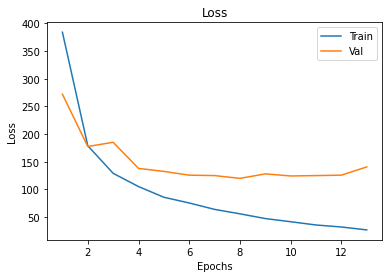

In [ ]:
import matplotlib.pyplot as plt

experiment_epoch = range(1, len(train_record[0]) + 1)
plt.plot(experiment_epoch, train_record[0], label='Train')
plt.plot(experiment_epoch, val_record[0], label='Val')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

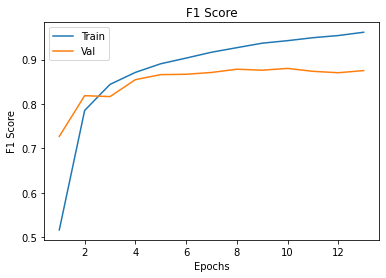

In [ ]:
experiment_epoch = range(1, len(train_record[1]) + 1)
plt.plot(experiment_epoch, train_record[1], label='Train')
plt.plot(experiment_epoch, val_record[1], label='Val')
plt.title('F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

从上面两张图可以看出，训练集的损失值和正确率都还在变好，但是验证集已经趋向于收敛，说明模型已经过拟合了。测试集上的结果是使用验证集上loss最低对应的模型参数测出来的，F1为0.8072，这个结果和验证集相比差了很多，我认为原因有以下几点：

1. CoNLL2003数据集网上没有官方下载的渠道（给的官网上面下载的文件需要导入reuters数据集），我使用的是GitHub上别人分享的txt文件，文件可能被修改过，导致测量结果和论文给出的差很远。
2. 机器学习一个基本的假设是训练集、验证集和测试集服从统一分布。然而，同样是没有训练只是作为测试的数据集，测试集上的表现远差于验证集上的表现，让人怀疑可能是数据集本身就有问题。